<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/Plots_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#@title Github
%%capture

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

import sys
!{sys.executable} -m pip install ipympl

In [ ]:
!ls "MD-SCPI/PDBs/MC/AS4/300K"

MR-AS4_10_MR-AS4.inpcrd_mc.dat.gz  MR-AS4_5_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_6_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_2_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_7_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_3_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_8_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_4_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_9_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_10_MR-AS4.inpcrd_mc.dat.gz  MR-AS4_5_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_6_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_2_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_7_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_3_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_8_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_4_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_9_MR-AS4.inpcrd_mc.dat.gz


In [8]:
import gzip
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import output
import numpy as np
import matplotlib as mpl
from scipy.stats import linregress

def ReadGz(path):
  #data = pd.read_csv(path, compression='gzip',  header=4, delimiter="  ")[['#', 'Step', 'Unnamed: 6', 'Unnamed: 7', ' RMSD']].rename({'#':'Step', 'Step':'Energy', 'Unnamed: 6':'RMSD', 'Unnamed: 7':'DX', ' RMSD':'DY'}, axis=1)
  file1 = gzip.open(path)
  a = file1.read()

  array, c = [], 0
  text = str(a).split()[11:]
  head = text[:14] # 20 

  for i in range(20,len(text)):
    c += 1
    if '\\n' in text[i]:
      text[i] = text[i].replace("\\n","")
      text[i] = text[i].replace("'","")
      words = [float(word) for word in text[i-c+1:i+1]]
      array.append(words) #text[i-c+1:i+1])
      c = 0

  array = np.array(array)
  data = pd.DataFrame({head[i]:array[:,i] for i in range(len(head))})
  return data

%matplotlib ipympl
output.enable_custom_widget_manager()

In [ ]:
#file1 = gzip.open('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')
#ReadGz('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')['Step']

In [9]:
temperatures = ['300K', '600K', '1200K', '2400K', '4800K', '9600K']
colors = ['brown', 'purple', 'red', 'green', 'orange', 'blue']
path = 'MD-SCPI/PDBs/MC/AS4/' #300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz'
gz_files = [f for f in listdir(path+temperatures[0]) if isfile(join(path+temperatures[0], f))]

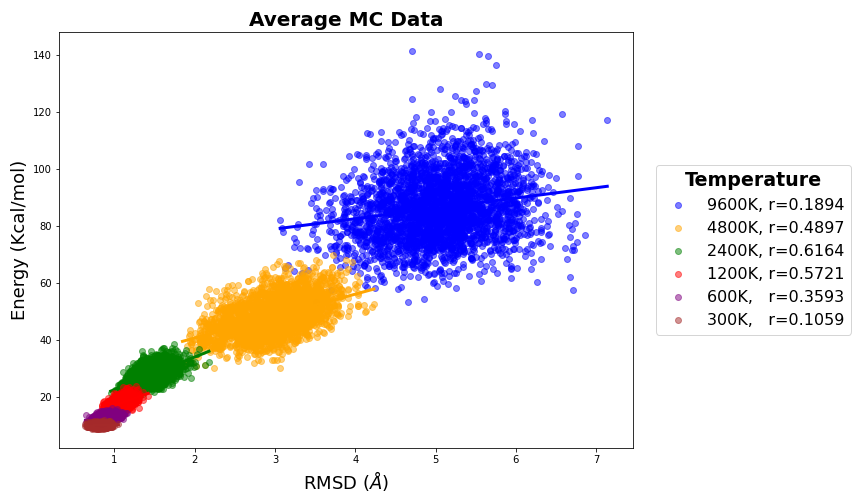

In [10]:
plt.close()
fig = plt.figure(figsize=(12,7))

for i in range(len(temperatures)-1,-1,-1):#list(reversed((temperatures))):
  rmsd, energy = [], []
  for file in gz_files:
    data = ReadGz(path+temperatures[i]+'/'+file)
    rmsd.append(data['RMSD']); energy.append(data['Energy'])
    #plt.plot(data['RMSD'], data['Energy'], 'o', label=temp)
  
  rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
  #m,b = np.polyfit(rmsd, energy, 1)
  slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)
  rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
  if len(temperatures[i]) == 4:
    label = temperatures[i]+',   r={}'.format(round(r_value,4))
  else:
    label = temperatures[i]+', r={}'.format(round(r_value,4))
  plt.plot(rmsd, energy, 'o', label=label, color=colors[i], alpha=0.5)
  plt.plot(rmsd_array, slope*rmsd_array+intercept, color=colors[i], lw=3)
  
plt.xlabel('RMSD ($\AA$)', fontsize='18'); plt.ylabel('Energy (Kcal/mol)', fontsize='18')
plt.legend(title='Temperature', bbox_to_anchor=(1.025, .7), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
plt.title('Average MC Data', fontsize='20', fontweight='bold')
#plt.ylim((0, 100)); plt.xlim((0, 10))


fig.tight_layout()